In [1]:
import numpy as np
import pickle
from os import listdir
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os 
from random import shuffle

# Loading the Data

In [2]:
import numpy as np
import pandas as pd  
import os 
from sklearn.datasets import load_files

In [3]:
data_dir =  r'C:\Users\Wave\Desktop\Test_vgg16\img\train'
data = load_files(data_dir)

# Data Preprocessing and exploring

In [4]:
folders=os.listdir(r'C:\Users\Wave\Desktop\Test_vgg16\img\train')
print(folders)

['chaplu', 'fahthalinejol', 'horapa', 'krapao', 'lemon', 'magrud', 'plu', 'sabtiger', 'saranae', 'yanang']


In [5]:
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

print('Data files - ',X)
print('Target labels - ',y)

Data files -  ['C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\fahthalinejol\\aug_0_1298.jpg'
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\sabtiger\\aug_0_8336.jpg'
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\fahthalinejol\\aug_0_5026.jpg'
 ...
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\krapao\\aug_0_1918.jpg'
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\yanang\\aug_0_372.jpg'
 'C:\\Users\\Wave\\Desktop\\Test_vgg16\\img\\train\\horapa\\aug_0_6768.jpg']
Target labels -  [1 7 1 ... 3 9 2]


# Load the images

In [6]:
from keras.preprocessing.image import img_to_array, load_img

def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 128,128
    for file_path in file_path_list:
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
        
    return arr
 
X = np.array(convert_img_to_arr(X))
print(X.shape)

(10565, 128, 128, 3)


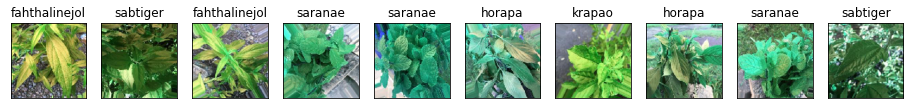

In [7]:
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize = (16,9))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [8]:
X = X.astype('float32')/255
no_of_classes = len(np.unique(y))
no_of_classes

10

In [9]:
y

array([1, 7, 1, ..., 3, 9, 2])

# converts a class vector (integers) to binary class matrix

In [10]:
from keras.utils import np_utils
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [11]:
 #80% train, 10% validation, and 10% test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,train_size=0.7,shuffle=True)

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.15)

In [12]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (128, 128, 3)


# Model

In [13]:
base_model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,input_shape=(128,128,3))

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [15]:
base_model.trainable = False

# Add head 

In [16]:
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(units=10,activation='softmax')(average_pooling_layer)

In [17]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

# train model

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss="categorical_crossentropy",metrics=["accuracy"])

C:\Users\Wave\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
model.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid),batch_size=128)

Epoch 1/10
58/58 [==============================] - 61s 1s/step - loss: 0.8167 - accuracy: 0.7655 - val_loss: 0.2592 - val_accuracy: 0.9391
Epoch 2/10
58/58 [==============================] - 59s 1s/step - loss: 0.1692 - accuracy: 0.9698 - val_loss: 0.1344 - val_accuracy: 0.9706
Epoch 3/10
58/58 [==============================] - 58s 1s/step - loss: 0.0973 - accuracy: 0.9861 - val_loss: 0.0890 - val_accuracy: 0.9832
Epoch 4/10
58/58 [==============================] - 57s 985ms/step - loss: 0.0657 - accuracy: 0.9930 - val_loss: 0.0662 - val_accuracy: 0.9895
Epoch 5/10
58/58 [==============================] - 57s 991ms/step - loss: 0.0483 - accuracy: 0.9961 - val_loss: 0.0534 - val_accuracy: 0.9937
Epoch 6/10
58/58 [==============================] - 57s 989ms/step - loss: 0.0377 - accuracy: 0.9980 - val_loss: 0.0430 - val_accuracy: 0.9958
Epoch 7/10
58/58 [==============================] - 60s 1s/step - loss: 0.0302 - accuracy: 0.9991 - val_loss: 0.0378 - val_accuracy: 0.9958
Epoch 8/10


In [21]:
(eval_loss, eval_accuracy) = model.evaluate(X_test, y_test, batch_size= 128, verbose=2)
print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss))

22/22 - 21s - loss: 0.0266 - accuracy: 0.9978 - 21s/epoch - 946ms/step
Accuracy: 99.78%
Loss: 0.02661299705505371


# Acuuracy and Loss graphs

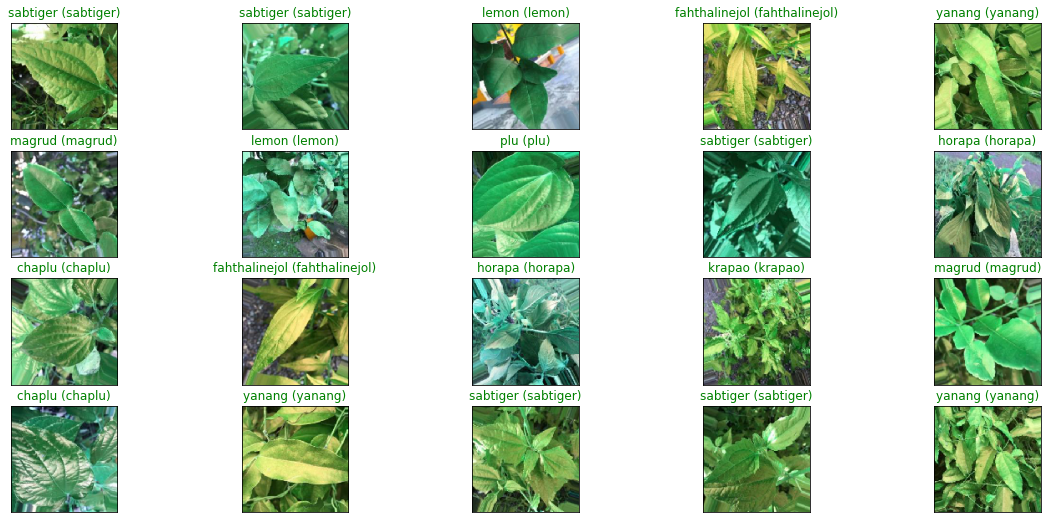

In [22]:
def visualize_pred(y_pred):
    fig = plt.figure(figsize=(20, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

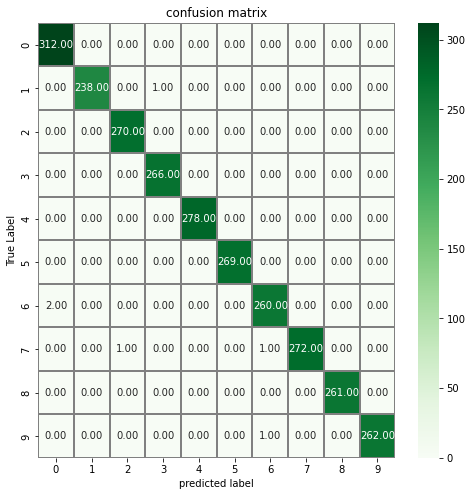

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [25]:
len(model.layers)

156

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
print("*******************Confusion matrix*******************")
print(confusion_matrix(Y_true,Y_pred_classes))
print("\n*******************Classification report*******************")
print(classification_report(Y_true,Y_pred_classes))

*******************Confusion matrix*******************
[[312   0   0   0   0   0   0   0   0   0]
 [  0 238   0   1   0   0   0   0   0   0]
 [  0   0 270   0   0   0   0   0   0   0]
 [  0   0   0 266   0   0   0   0   0   0]
 [  0   0   0   0 278   0   0   0   0   0]
 [  0   0   0   0   0 269   0   0   0   0]
 [  2   0   0   0   0   0 260   0   0   0]
 [  0   0   1   0   0   0   1 272   0   0]
 [  0   0   0   0   0   0   0   0 261   0]
 [  0   0   0   0   0   0   1   0   0 262]]

*******************Classification report*******************
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       312
           1       1.00      1.00      1.00       239
           2       1.00      1.00      1.00       270
           3       1.00      1.00      1.00       266
           4       1.00      1.00      1.00       278
           5       1.00      1.00      1.00       269
           6       0.99      0.99      0.99       262
           7       1